In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import numpy as np

In [2]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [12]:
agent_df = pd.read_pickle('agent_output_NO_ADS.pkl')
joint_calendar_df = pd.read_pickle('joint_calendar_NO_ADS.pkl')

In [13]:
# Reset index and move it to columns
agent_df_reset = agent_df.reset_index()

# Create a date range starting from '2021-01-03' with a frequency of one week
# The number of periods is the number of unique 'Step' values in agent_df
dates = pd.date_range(start='2021-01-03', periods=agent_df_reset['Step'].nunique(), freq='W')

# Create a DataFrame mapping 'Step' to 'Date'
step_to_date = pd.DataFrame({'Step': range(0, len(dates)), 'Date': dates})

# Merge this DataFrame with agent_df to add the 'Date' column
agent_df_reset = agent_df_reset.merge(step_to_date, on='Step')

# Set 'Step' and 'AgentID' back as indices
agent_df = agent_df_reset.set_index(['Step', 'AgentID'])

In [14]:

def calculate_total_purchases(agent_df):
    '''
    Computes total purchases per brand per step from agent level output
    Used as sanity check for model level output
    '''
    # Initialize empty lists to store the results
    total_purchases_A = []
    total_purchases_B = []
    dates = []
    steps = []

    # Iterate over the 'Purchased_This_Step' column
    for index, row in agent_df.iterrows():
        # Append the number of purchases for each brand to the respective list
        total_purchases_A.append(row['Purchased_This_Step']['A'])
        total_purchases_B.append(row['Purchased_This_Step']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the total purchases for each brand
    total_purchases_df = pd.DataFrame({
        'Total_Purchases_A': total_purchases_A,
        'Total_Purchases_B': total_purchases_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and sum the purchases
    total_purchases_df = total_purchases_df.groupby(['Date']).sum().reset_index()

    return total_purchases_df

In [15]:
total_purchases_df = calculate_total_purchases(agent_df)

In [16]:
# Calculate total dollar sales for Brand A and Brand B and add them to the total_purchases_df
# Also add price column for A and B to the total_purchases_df dataframe
total_purchases_df['Price_A'] = joint_calendar_df[('A', 'price')]
total_purchases_df['Price_B'] = joint_calendar_df[('B', 'price')]
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Purchases_A'] * total_purchases_df['Price_A']
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Purchases_B'] * total_purchases_df['Price_B']


In [17]:
# Set correct data types
total_purchases_df['Price_A'] = total_purchases_df['Price_A'].astype(float)
total_purchases_df['Price_B'] = total_purchases_df['Price_B'].astype(float)
total_purchases_df['Total_Purchases_A'] = total_purchases_df['Total_Purchases_A'].astype(float)
total_purchases_df['Total_Purchases_B'] = total_purchases_df['Total_Purchases_B'].astype(float)
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Sales_A'].astype(float)
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Sales_B'].astype(float)

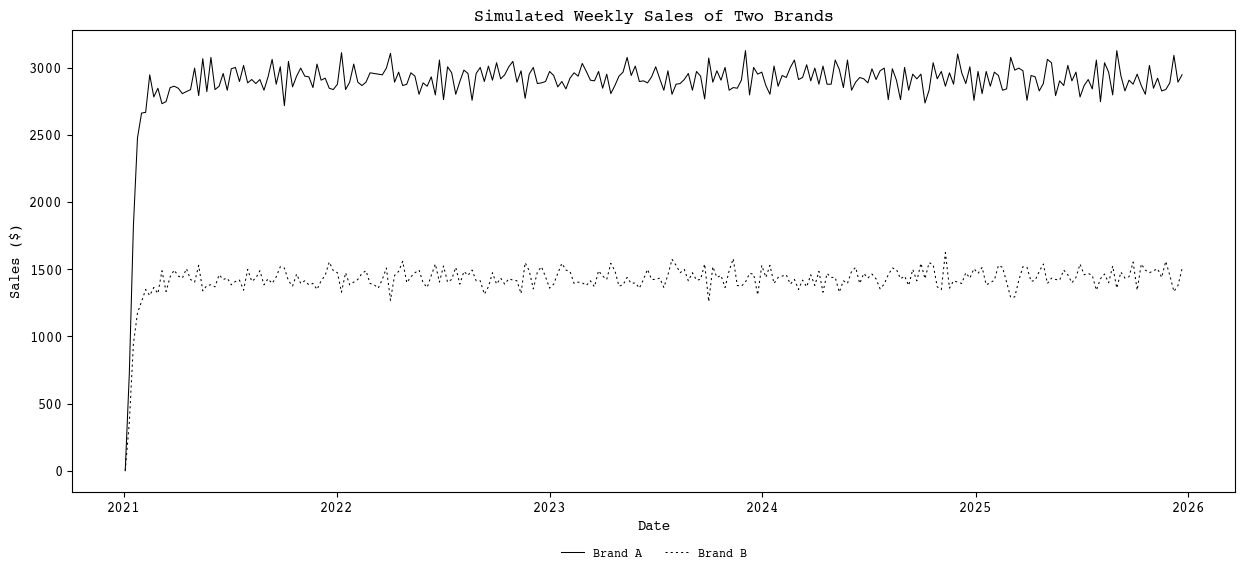

In [18]:
# Create the plot
plt.figure(figsize=(15,6))

plt.plot(total_purchases_df['Date'], total_purchases_df['Total_Sales_A'], label='Brand A', color='black')
plt.plot(total_purchases_df['Date'], total_purchases_df['Total_Sales_B'], label='Brand B', color='black', linestyle='--', dashes=[2,3])

plt.title('Simulated Weekly Sales of Two Brands')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.savefig("NO_ADS_ONLY.png", dpi=200)
plt.show()

In [12]:
def calculate_average_adstock(agent_df):
    '''
    Computes average adstock per brand per step from agent level output
    '''
    # Initialize empty lists to store the results
    average_adstock_A = []
    average_adstock_B = []
    dates = []
    steps = []

    # Iterate over the 'Ad_Stock' column
    for index, row in agent_df.iterrows():
        # Append the adstock for each brand to the respective list
        average_adstock_A.append(row['Adstock']['A'])
        average_adstock_B.append(row['Adstock']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the average adstock for each brand
    average_adstock_df = pd.DataFrame({
        'Average_Adstock_A': average_adstock_A,
        'Average_Adstock_B': average_adstock_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and calculate the average adstock
    average_adstock_df = average_adstock_df.groupby(['Date']).mean().reset_index()

    return average_adstock_df

In [13]:
average_adstock_df = calculate_average_adstock(agent_df)

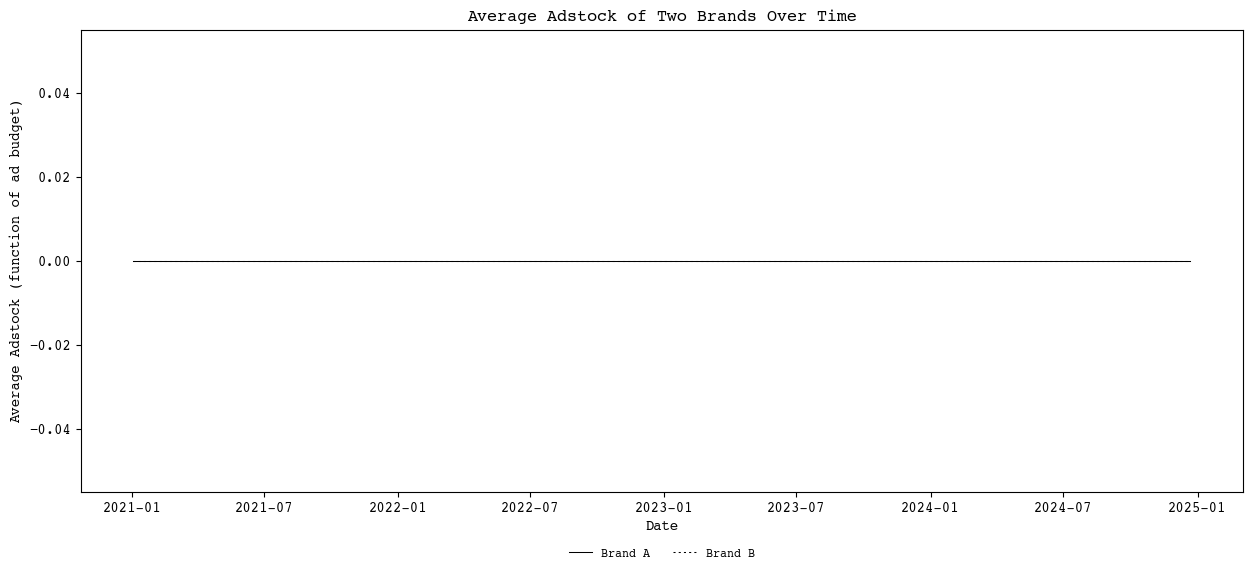

In [15]:
# Create the plot
plt.figure(figsize=(15,6))

plt.plot(average_adstock_df['Date'], average_adstock_df['Average_Adstock_A'], label='Brand A', color='black')
plt.plot(average_adstock_df['Date'], average_adstock_df['Average_Adstock_B'], label='Brand B', color='black', linestyle='--', dashes=[2,3])

plt.title('Average Adstock of Two Brands Over Time')
plt.xlabel('Date')
plt.ylabel('Average Adstock (function of ad budget)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.savefig("adstock_no_ad.png", dpi=200)
plt.show()

In [14]:
import matplotlib.pyplot as plt

def plot_agent_adstock(agent_df, agent_id):
    '''
    Plots adstock per brand per step for a specific agent from agent level output
    '''
    # Filter the DataFrame for the specified agent
    agent_df_filtered = agent_df.xs(agent_id, level='AgentID')

    # Initialize empty lists to store the results
    adstock_A = []
    adstock_B = []
    dates = []

    # Iterate over the 'Ad_Stock' column
    for index, row in agent_df_filtered.iterrows():
        # Append the adstock for each brand to the respective list
        adstock_A.append(row['Adstock']['A'])
        adstock_B.append(row['Adstock']['B'])
        dates.append(row['Date'])

    # Create the plot
    plt.figure(figsize=(15,6))

    plt.plot(dates, adstock_A, label='Brand A', color='black')
    plt.plot(dates, adstock_B, label='Brand B', color='black', linestyle='--', dashes=[2,3])

    plt.title(f'Adstock of Two Brands Over Time for Agent {agent_id}')
    plt.xlabel('Date')
    plt.ylabel('Adstock')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

    plt.show()

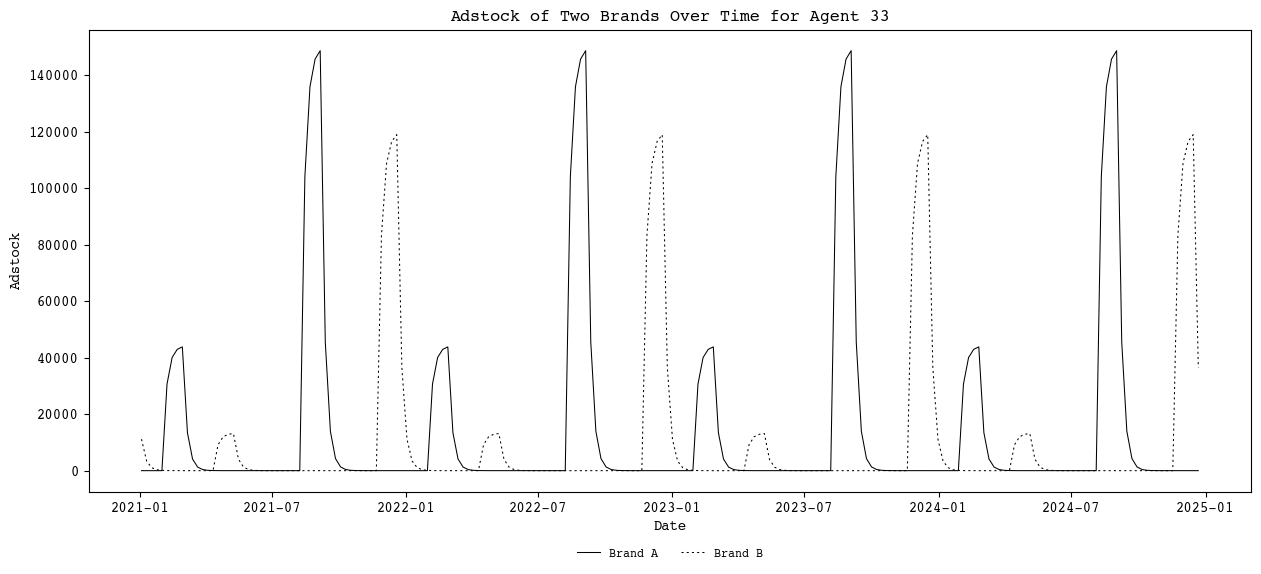

In [15]:
plot_agent_adstock(agent_df, 33)

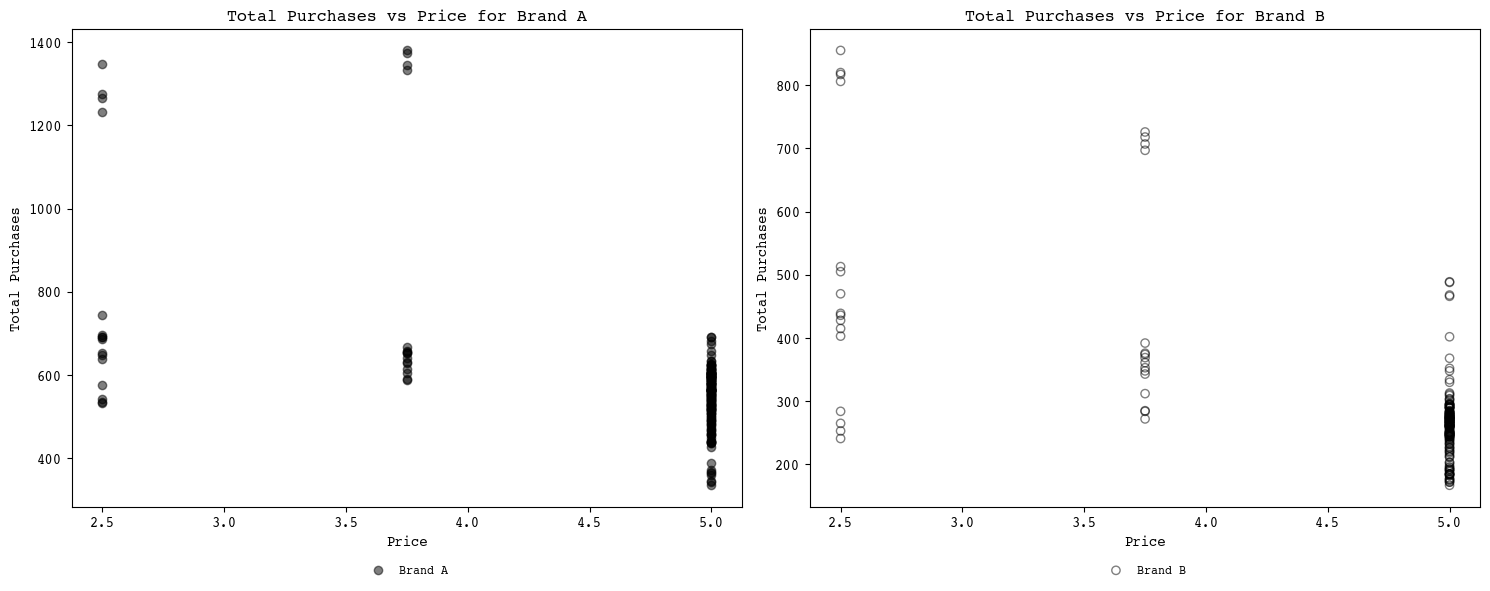

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

# Scatter plot for Brand A with filled black circles and transparency
axs[0].scatter(total_purchases_df['Price_A'], total_purchases_df['Total_Purchases_A'], 
            label='Brand A', color='black', alpha=0.5)
axs[0].set_title('Total Purchases vs Price for Brand A')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Total Purchases')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

# Scatter plot for Brand B with unfilled black circles and transparency
axs[1].scatter(total_purchases_df['Price_B'], total_purchases_df['Total_Purchases_B'], 
            label='Brand B', facecolor='none', edgecolor='black', alpha=0.5)
axs[1].set_title('Total Purchases vs Price for Brand B')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Total Purchases')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.tight_layout()
plt.show()


In [17]:
# Take the natural log of 'Total_Purchases_A' and 'Price_A' for Brand A
total_purchases_df['ln_Total_Purchases_A'] = np.log(total_purchases_df['Total_Purchases_A'])
total_purchases_df['ln_Price_A'] = np.log(total_purchases_df['Price_A'])

# Define the dependent variable and the independent variables
Y = total_purchases_df['ln_Total_Purchases_A']
X = total_purchases_df['ln_Price_A']
X = sm.add_constant(X)  # Add a constant to the independent variables

# Fit the model
model = sm.OLS(Y, X)
results = model.fit()

# The coefficient of 'ln_Price_A' is the price elasticity of demand for Brand A
elasticity_A = results.params['ln_Price_A']

# Repeat the process for Brand B
total_purchases_df['ln_Total_Purchases_B'] = np.log(total_purchases_df['Total_Purchases_B'])
total_purchases_df['ln_Price_B'] = np.log(total_purchases_df['Price_B'])

Y = total_purchases_df['ln_Total_Purchases_B']
X = total_purchases_df['ln_Price_B']
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

elasticity_B = results.params['ln_Price_B']

In [18]:
elasticity_A

-0.5592738378953722

In [19]:
def get_agent_purchases_and_price(agent_df, joint_calendar_df, agent_id):
    '''
    Retrieves purchases and price per brand per step for a specific agent from agent level output
    '''
    # Filter the DataFrame for the specified agent
    agent_df_filtered = agent_df.xs(agent_id, level='AgentID')

    # Initialize empty lists to store the results
    purchases_A = []
    purchases_B = []
    price_A = []
    price_B = []
    dates = []

    # Iterate over the 'Purchased_This_Step' and 'Current_Price' columns
    for index, row in agent_df_filtered.iterrows():
        # Append the purchases and price for each brand to the respective list
        purchases_A.append(row['Purchased_This_Step']['A'])
        purchases_B.append(row['Purchased_This_Step']['B'])
        price_A.append(joint_calendar_df.loc[index, ('A', 'price')])
        price_B.append(joint_calendar_df.loc[index, ('B', 'price')])
        dates.append(row['Date'])

    # Create a new DataFrame with the purchases and price for each brand
    agent_purchases_and_price_df = pd.DataFrame({
        'Date': dates,
        'Purchases_A': purchases_A,
        'Price_A': price_A,
        'Purchases_B': purchases_B,
        'Price_B': price_B,
    })

    return agent_purchases_and_price_df

In [20]:
agent_purchases_and_price_df = get_agent_purchases_and_price(agent_df, joint_calendar_df, 431)

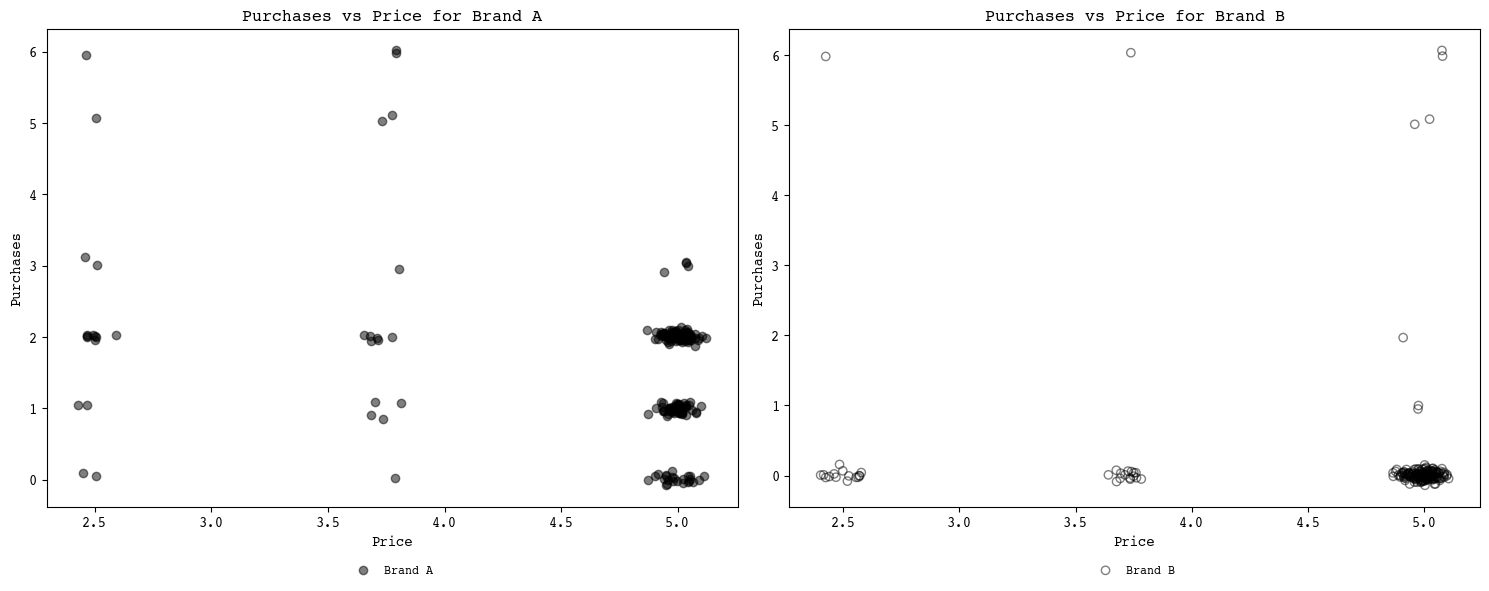

In [21]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(15,6))

# Scatter plot for Brand A with filled black circles and transparency
axs[0].scatter(agent_purchases_and_price_df['Price_A'] + np.random.normal(0, 0.05, size=len(agent_purchases_and_price_df['Price_A'])), 
               agent_purchases_and_price_df['Purchases_A'] + np.random.normal(0, 0.05, size=len(agent_purchases_and_price_df['Purchases_A'])), 
               label='Brand A', color='black', alpha=0.5)
axs[0].set_title('Purchases vs Price for Brand A')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Purchases')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

# Scatter plot for Brand B with unfilled black circles and transparency
axs[1].scatter(agent_purchases_and_price_df['Price_B'] + np.random.normal(0, 0.05, size=len(agent_purchases_and_price_df['Price_B'])), 
               agent_purchases_and_price_df['Purchases_B'] + np.random.normal(0, 0.05, size=len(agent_purchases_and_price_df['Purchases_B'])), 
               label='Brand B', facecolor='none', edgecolor='black', alpha=0.5)
axs[1].set_title('Purchases vs Price for Brand B')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Purchases')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.tight_layout()
plt.show()

In [22]:
# Define the dependent variable and the independent variables
Y = agent_purchases_and_price_df['Purchases_A']
X = agent_purchases_and_price_df['Price_A']
X = sm.add_constant(X)  # Add a constant to the independent variables

# Fit the model
poisson_model = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# The coefficient of 'Price_A' is the price elasticity of demand for Brand A
elasticity_A = poisson_results.params['Price_A']

# Repeat the process for Brand B
Y = agent_purchases_and_price_df['Purchases_B']
X = agent_purchases_and_price_df['Price_B']
X = sm.add_constant(X)

poisson_model = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

elasticity_B = poisson_results.params['Price_B']

In [23]:
elasticity_A

-0.2113078115159031

In [24]:
elasticity_B

-0.4165851934399495

In [25]:
# Define the dependent variable and the independent variables
Y = agent_purchases_and_price_df['Purchases_A']
X = agent_purchases_and_price_df['Price_A']
X = sm.add_constant(X)  # Add a constant to the independent variables

# Fit the Zero-Inflated Poisson model
zip_model_A = sm.ZeroInflatedPoisson(Y, X).fit()

# The coefficient of 'Price_A' is the price elasticity of demand for Brand A
elasticity_A = zip_model_A.params['Price_A']

# Repeat the process for Brand B
Y = agent_purchases_and_price_df['Purchases_B']
X = agent_purchases_and_price_df['Price_B']
X = sm.add_constant(X)

zip_model_B = sm.ZeroInflatedPoisson(Y, X).fit()

elasticity_B = zip_model_B.params['Price_B']

Optimization terminated successfully.
         Current function value: 1.416299
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.269083
         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27


In [26]:
elasticity_A

-0.21134619060255036

In [27]:

elasticity_B

-0.2284306112581729

In [29]:
zip_model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:             Purchases_A   No. Observations:                  208
Model:             ZeroInflatedPoisson   Df Residuals:                      206
Method:                            MLE   Df Model:                            1
Date:                 Mon, 20 May 2024   Pseudo R-squ.:                 0.01613
Time:                         21:04:23   Log-Likelihood:                -294.59
converged:                        True   LL-Null:                       -299.42
Covariance Type:             nonrobust   LLR p-value:                  0.001884
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -14.6905    183.278     -0.080      0.936    -373.908     344.527
const             1.4473      0.300      4.818      0.000       0.859       2.036
Price_A          -0.2113      0.064     -3.278      0.001      -0.338      -0.085
=================================================================================
"""

In [33]:
just_A = agent_purchases_and_price_df[['Purchases_A','Price_A']]

In [36]:
just_A = just_A[just_A['Purchases_A'] != 0]

In [37]:
just_A

,Purchases_A,Price_A
0,1,5.0
1,2,5.0
2,2,5.0
3,2,5.0
4,1,5.0
...,...,...
202,2,5.0
203,1,5.0
204,2,5.0
205,2,5.0


In [39]:
def estimate_elasticity(df, purchases_col, price_col):
    '''
    Estimates the elasticity of demand coefficient using the log-log method.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the data
    purchases_col (str): Name of the column in df representing purchases
    price_col (str): Name of the column in df representing prices
    
    Returns:
    float: Estimated elasticity of demand coefficient
    '''
    # Take the natural log of purchases and prices
    df['ln_purchases'] = np.log(df[purchases_col])
    df['ln_price'] = np.log(df[price_col])

    # Define the dependent variable and the independent variables
    Y = df['ln_purchases']
    X = df['ln_price']
    X = sm.add_constant(X)  # Add a constant to the independent variables

    # Fit the model
    model = sm.OLS(Y, X)
    results = model.fit()

    # The coefficient of 'ln_price' is the price elasticity of demand
    elasticity = results.params['ln_price']

    return elasticity

In [40]:
estimate_elasticity(just_A,'Purchases_A','Price_A')

/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_3854/259145669.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ln_purchases'] = np.log(df[purchases_col])
/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_3854/259145669.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ln_price'] = np.log(df[price_col])


-0.5747935317499039

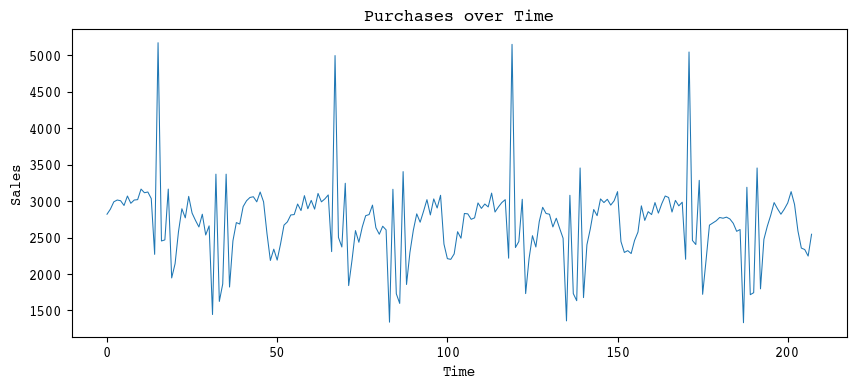

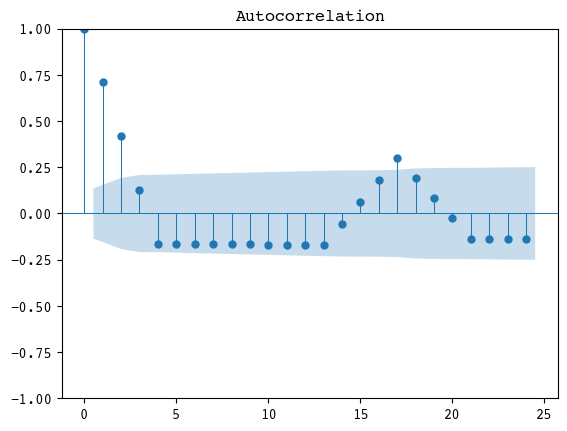

In [41]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot the data
plt.figure(figsize=(10,4))
plt.plot(total_purchases_df['Total_Sales_A'])
plt.title('Purchases over Time')
plt.ylabel('Sales')
plt.xlabel('Time')
plt.show()

# Plot the Autocorrelation function
plot_acf(agent_purchases_and_price_df['Price_A'])
plt.show()